torch.Size([1000, 8])


C:\Users\kevin\AppData\Local\Temp\ipykernel_21936\2671937943.py:111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i].scatter(d_samples[:, 2*i], d_samples[:, 2*i+1], cmap='tab10')


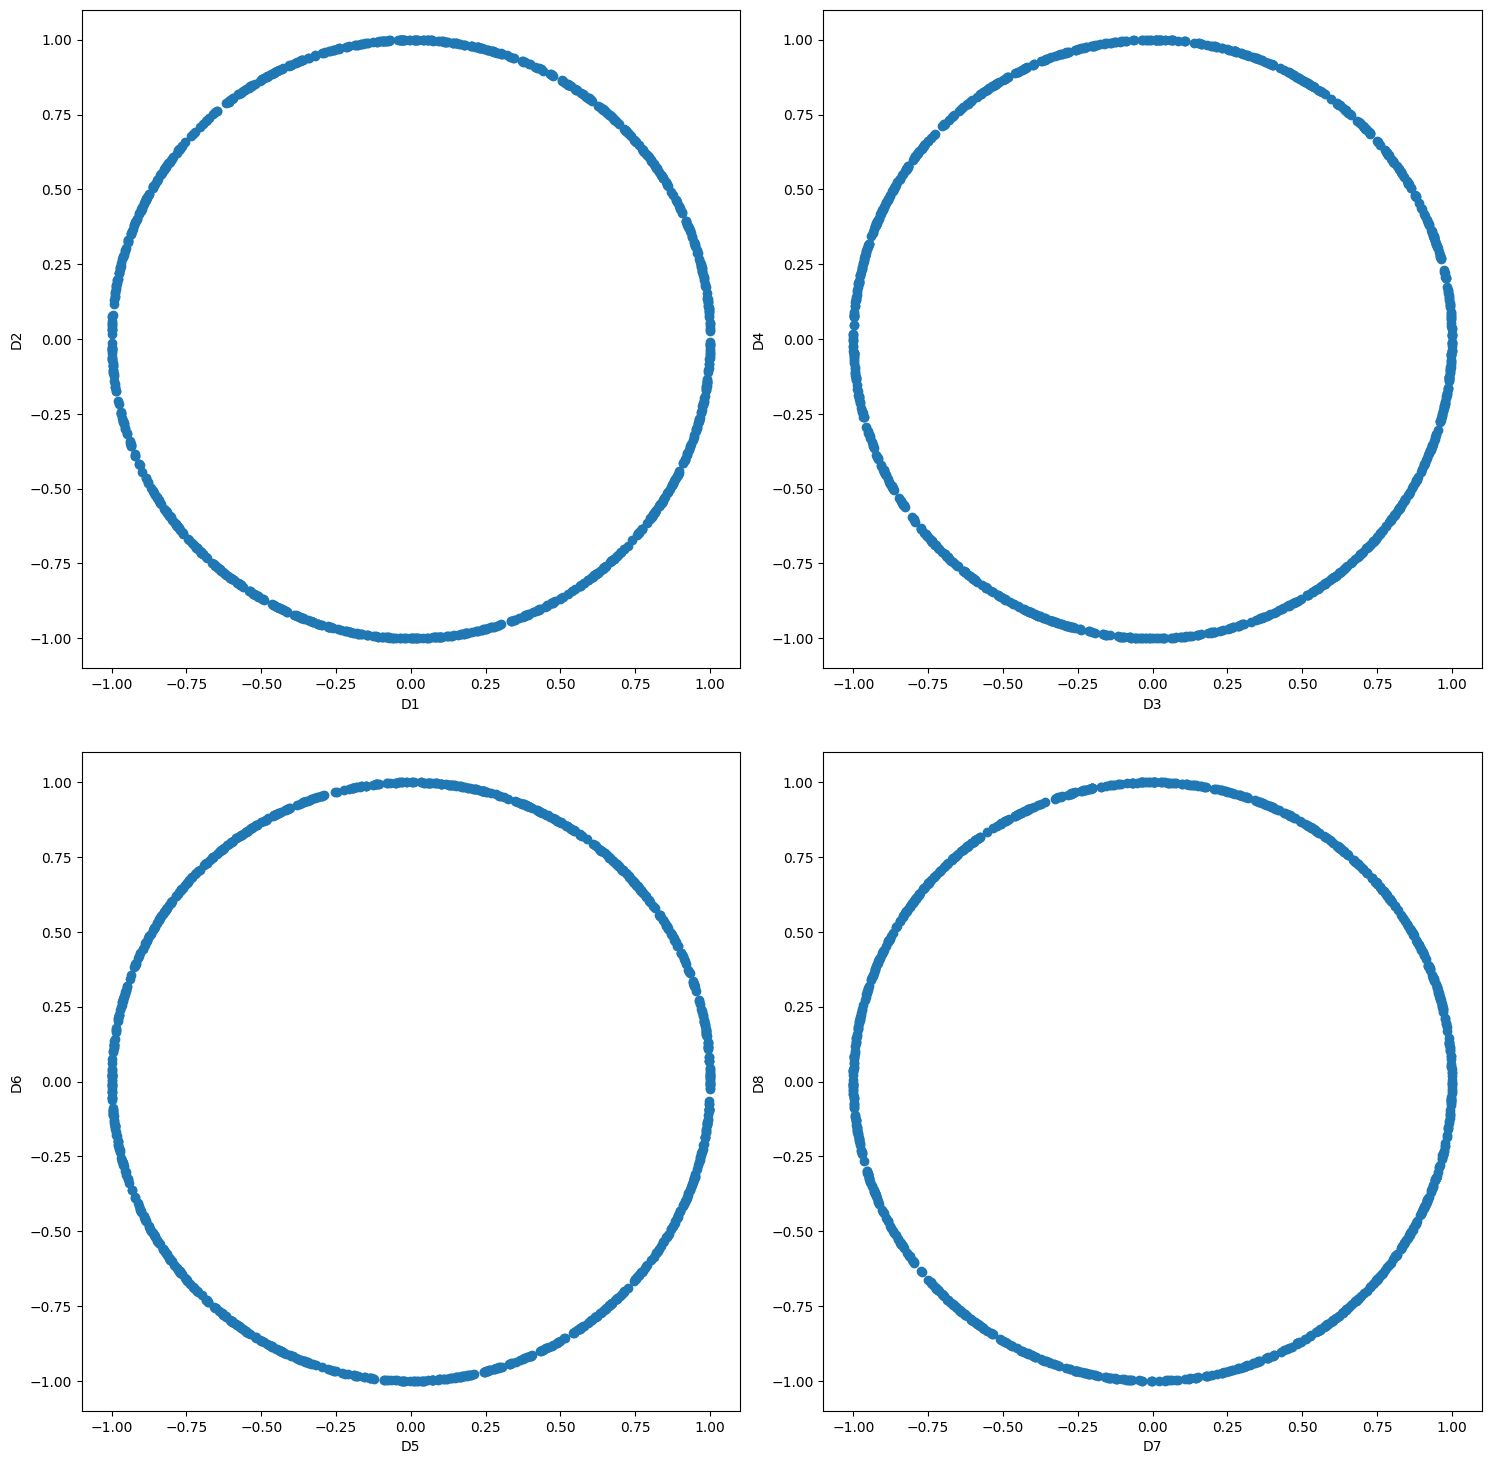

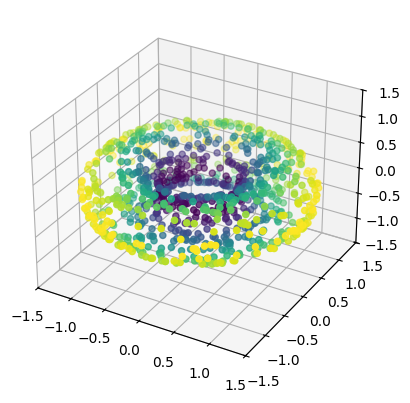

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

def draw_samples(samples, latent_dim, scaling_factor=1.0): # Latent dim is 3
    d1 = torch.randn(samples, 2*latent_dim)
    d1 = d1.reshape(samples, -1, 2)
    d1 = d1 / torch.norm(d1, dim=2, keepdim=True)
    d1 = d1.reshape(samples, -1)
    return d1 / scaling_factor

# Define a method to compute the expected scaling factor
def compute_scaling_factor(latent_dim, num_samples=1000):
    # Generate samples
    samples = draw_samples(num_samples, latent_dim)
    # Compute expected dot product std
    dot_products = torch.matmul(samples, samples.t())
    return torch.std(dot_products, unbiased=False)**0.5

def project_to_3d(samples, r1=1.0, r2=0.5):
    # Project to 3D torus
    x = (r1 + r2*samples[:, 0]) * samples[:, 2]
    y = (r1 + r2*samples[:, 0]) * samples[:, 3]
    z = r2*samples[:, 1]
    samples_3d = np.stack((x, y, z), axis=-1)
    return samples_3d

# Define the model
class AE(nn.Module):
    def __init__(self, latent_dim=16):
        super(AE, self).__init__()
        self.latent_dim = latent_dim
        self.scaling_factor = compute_scaling_factor(latent_dim)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, self.latent_dim*2),
            # nn.Linear(28*28*3, self.latent_dim*4),
            # nn.Linear(28*28*3, self.latent_dim*2 + 1),
            # nn.Tanh(), # Constrain to -1, 1
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim*2, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28*3),
            nn.ELU(),
            nn.RMSNorm(28*28*3),
            nn.Linear(28*28*3, 28*28),
        )

    def encode(self, x):
        l = self.encoder(x)
        h = l.reshape(-1, self.latent_dim, 2) # [batch, latent_dim, 2]
        h = h / (torch.norm(h, dim=2, keepdim=True) + 1e-6) # Normalize
        h = h.reshape(-1, self.latent_dim*2) # [batch, latent_dim*2]
        h = h #/ self.scaling_factor # Scale
        # l1 = l[:, :self.latent_dim*2]
        # l2 = l[:, self.latent_dim*2:]
        # # h = l1 + l2.abs() * torch.randn_like(l2) # This random part is to fill up more space
        # h = l1 + l2.abs() * 2.0 * (torch.rand_like(l2) - 0.5) # This random part is to fill up more space
        # h = h.reshape(-1, self.latent_dim, 2) # [batch, latent_dim, 2]
        # h = h / (torch.norm(h, dim=2, keepdim=True) + 1e-6)
        # h = h.reshape(-1, self.latent_dim*2)
        # h = h #/ self.scaling_factor
        return h, l

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        h, l = self.encode(x)
        return self.decode(h), (h, l)

# Plot samples for each plane
samples = 1000
latent_dim = 4  # Change this to the actual latent dimension
# 10 is too much for MNIST

# Compute scaling factor
# scaling_factor = compute_scaling_factor(latent_dim)
scaling_factor = 1.0

# Generate samples
d_samples = draw_samples(samples, latent_dim, scaling_factor)
print(d_samples.shape)

# Create the subplots with the calculated number of rows and columns
n = latent_dim
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(latent_dim):
    axes[i].scatter(d_samples[:, 2*i], d_samples[:, 2*i+1], cmap='tab10')
    axes[i].set_xlabel(f'D{2*i+1}')
    axes[i].set_ylabel(f'D{2*i+2}')
    axes[i].set_aspect('equal', 'box')  # Make the aspect ratio equal

# Hide any unused subplots
for j in range(latent_dim, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.close()

# Project to 3D
d3 = project_to_3d(d_samples)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d3[:, 0], d3[:, 1], d3[:, 2], c=torch.norm(torch.tensor(d3), dim=1).detach().numpy())
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
plt.show()
plt.close()

In [2]:
# Build model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./mnist_data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
myae = AE(latent_dim=latent_dim).to(device)
print(sum(p.numel() for p in myae.parameters() if p.requires_grad))

# Show variance of samples (diagonal)
mean_samples = torch.mean(d_samples, dim=0)
std_samples = torch.std(d_samples, dim=0, unbiased=True)
d_samples_m = d_samples - mean_samples
cov_samples = torch.matmul(d_samples_m.T, d_samples_m) / samples
print(mean_samples)
print(std_samples)
print(cov_samples)
mean_samples = mean_samples.to(device)
std_samples = std_samples.to(device)
cov_samples = cov_samples.to(device)

Using device cuda
14808984
tensor([ 0.0177, -0.0081, -0.0046, -0.0086,  0.0111,  0.0077,  0.0080,  0.0294])
tensor([0.6832, 0.7307, 0.7057, 0.7091, 0.7013, 0.7135, 0.7107, 0.7036])
tensor([[ 4.6623e-01,  7.8606e-03,  7.7728e-04,  3.2995e-02,  5.7924e-04,
          2.3565e-03,  2.3836e-02,  1.8021e-02],
        [ 7.8606e-03,  5.3339e-01, -9.0120e-03,  1.7112e-02, -2.6082e-03,
          2.1203e-02, -3.8319e-02, -1.2034e-02],
        [ 7.7728e-04, -9.0120e-03,  4.9754e-01, -9.0367e-03, -8.8673e-03,
          7.2048e-05,  2.2378e-02, -4.6216e-03],
        [ 3.2995e-02,  1.7112e-02, -9.0367e-03,  5.0237e-01, -5.8498e-03,
          1.4159e-02,  3.1067e-02,  9.6522e-03],
        [ 5.7924e-04, -2.6082e-03, -8.8673e-03, -5.8498e-03,  4.9127e-01,
          9.1806e-03,  1.0871e-02, -1.7048e-03],
        [ 2.3565e-03,  2.1203e-02,  7.2048e-05,  1.4159e-02,  9.1806e-03,
          5.0854e-01, -2.5787e-02, -2.0017e-02],
        [ 2.3836e-02, -3.8319e-02,  2.2378e-02,  3.1067e-02,  1.0871e-02,
       

In [3]:
import schedulefree
opt_ae = schedulefree.AdamWScheduleFree(myae.parameters(), lr=1e-3, betas=(0.95, 0.9999), weight_decay=1e-6, warmup_steps=100)
loss_fn = nn.L1Loss()
epochs = 200
# AE_samples = 2
pbar = tqdm(total=epochs)
for epoch in range(epochs):
    myae.train()
    for x, _ in train_loader:
        # Get reconstruction and latent representation
        opt_ae.train()
        x = x.to(device)
        opt_ae.zero_grad()
        recon, z = myae(x)

        # Reconstruction loss
        recon_loss = loss_fn(recon, x)

        # Sample multiple times
        # zs = []
        # for _ in range(AE_samples):
        #     recon, z = myae(x)
        #     zs.append(z[0])
        # zs = torch.cat(zs, dim=0)

        # Moment matching
        zs = z[0]
        reg_loss = (torch.mean(zs, dim=0) - mean_samples).pow(2).sum()
        z_m = zs - torch.mean(zs, dim=0)
        cov_z = torch.matmul(z_m.T, z_m) / zs.size(0)
        reg_loss = reg_loss + (cov_z - cov_samples).pow(2).sum()

        # Get gradients (automatic differentiation)
        loss = recon_loss + reg_loss
        # loss = recon_loss + 1e6*reg_loss # Doesn't matter
        loss.backward()
        opt_ae.step()
        pbar.set_postfix({'Loss': loss.item(), 'Recon': recon_loss.item(), 'Reg': reg_loss.item()})
    pbar.update(1)
pbar.close()
opt_ae.eval()

100%|██████████| 200/200 [53:16<00:00, 15.98s/it, Loss=0.322, Recon=0.12, Reg=0.201]  


In [4]:
# Go through the entire training dataset and label the latent space
myae.eval()
all_latents = []
all_labels = []
for x, y in train_loader:
    x = x.to(device)
    with torch.no_grad():
        _, z = myae(x)
        z = z[0].cpu()
    all_latents.append(z)
    all_labels.append(y)
all_latents = torch.cat(all_latents)
all_labels = torch.cat(all_labels)

In [5]:
import umap
# Umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_latents.cpu().numpy())

c:\Users\kevin\Desktop\Test\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


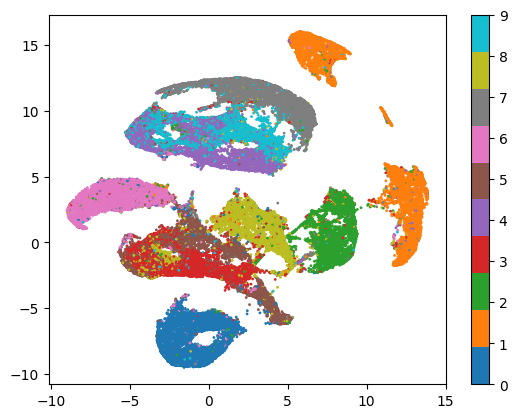

In [6]:
%matplotlib inline
plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels.cpu().numpy(), cmap='tab10', s=1)
plt.colorbar()
plt.show()
plt.close()

In [7]:
# UMAP on original data
reducer2 = umap.UMAP()
embedding2 = reducer2.fit_transform(train_dataset.data.view(-1, 28*28).numpy())

c:\Users\kevin\Desktop\Test\env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


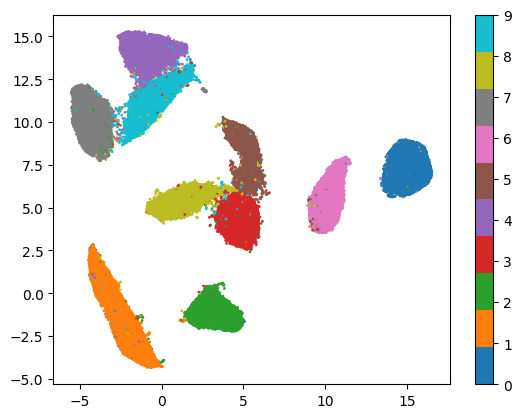

In [8]:
# Plot UMAP of original data
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=train_dataset.targets.numpy(), cmap='tab10', s=1)
plt.colorbar()
plt.show()
plt.close()

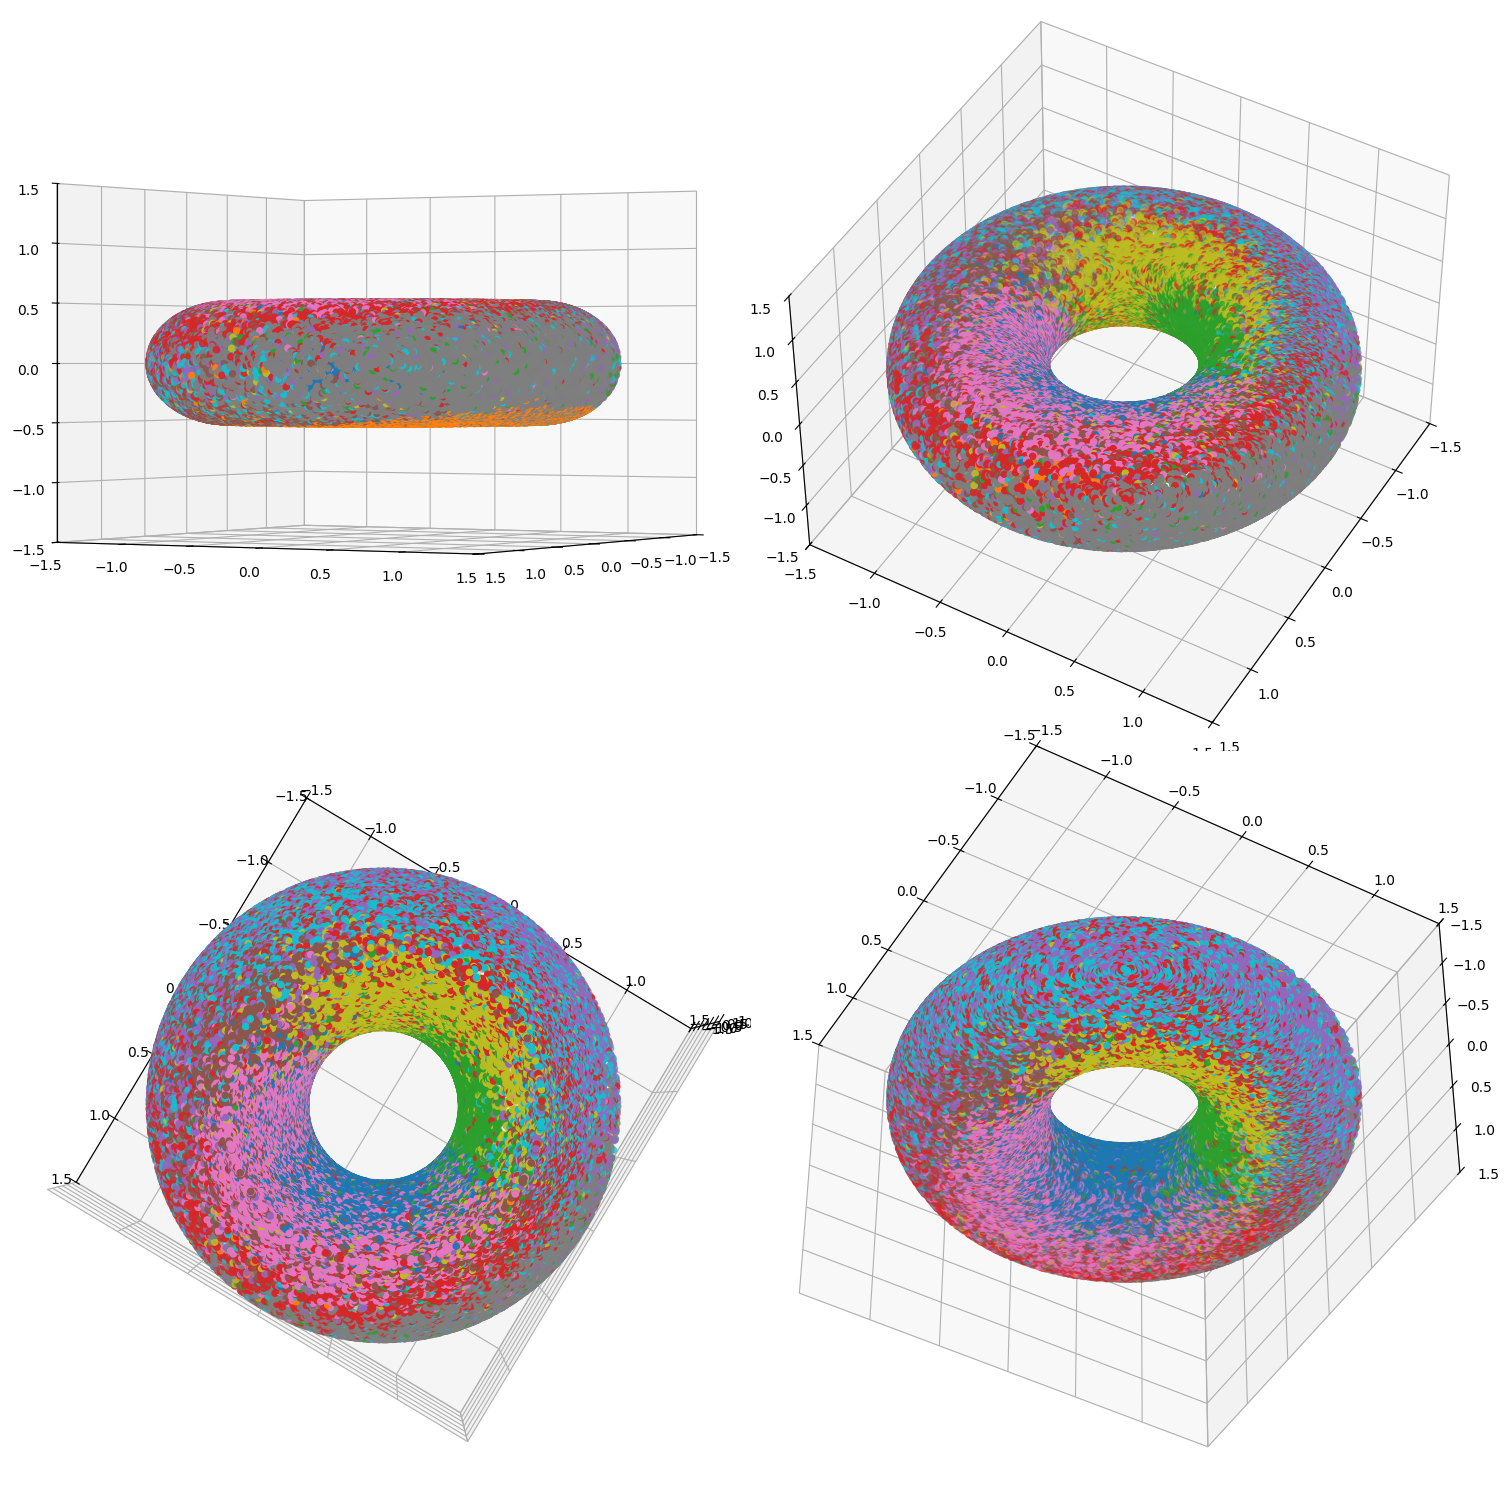

In [10]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget
%matplotlib inline

# Convert tensors to numpy arrays for plotting
latents_np = all_latents.cpu().numpy()
labels_np = all_labels.cpu().numpy()

# Project latents to 3D
latents_np = project_to_3d(latents_np)
# latents_np = project_to_3d(latents_np[:, 14:]) # We increment by 2 everytime

num_subplots = 2  # Number of subplots per row/column
fig, axes = plt.subplots(num_subplots, num_subplots, figsize=(15, 15), subplot_kw={'projection': '3d'})

# Plot 3D samples colored by norm in each subplot with different angles
angles = np.linspace(0, 180, num_subplots * num_subplots, endpoint=False)
for ax, angle in zip(axes.flat, angles):
    ax.scatter(latents_np[:, 0], latents_np[:, 1], latents_np[:, 2], c=labels_np, cmap='tab10')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-1.5, 1.5)
    ax.view_init(elev=angle, azim=30)

plt.tight_layout()
plt.show()
plt.close()

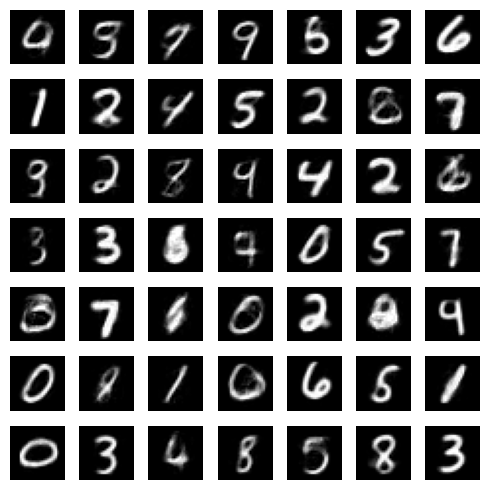

In [79]:
import matplotlib.pyplot as plt
import torch
# Draw samples from AE
myae.eval()
samples = draw_samples(49, latent_dim).to(device)
# samples = all_latents[np.random.choice(all_latents.shape[0], 25, replace=False)].to(device)
recon = myae.decode(samples)

# Determine grid size (close to square)
num_samples = samples.shape[0]
grid_size = int(num_samples**0.5)
if grid_size**2 < num_samples:
    grid_size += 1

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# Plot samples in grid
for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        if idx < num_samples:
            img = recon[idx].cpu().detach().numpy().squeeze()  # Assuming recon is in CHW format
            img = img.clip(-1, 1)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()